In [ ]:
dataframe = 

In [14]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [42]:
data = mags.toPandas()

In [29]:
from pandas import Series
from matplotlib import pyplot

In [49]:
series = Series.from_csv('/home/user/elicon/data/mars-earthquakes.csv', header=0)

In [56]:
series.sort_index()

time
2018-03-02 15:25:23.220    36.582000
2018-03-02 16:55:04.850    36.037167
2018-03-02 20:22:13.600    40.466500
2018-03-03 07:00:12.670    33.477333
2018-03-03 11:04:04.620    37.846667
2018-03-05 13:54:41.520    40.160167
2018-03-05 22:19:44.940    38.778000
2018-03-06 12:38:16.730    37.001667
2018-03-06 12:44:06.150    37.004167
2018-03-06 17:41:28.950    34.391167
2018-03-06 22:21:26.720    37.463167
2018-03-07 04:26:43.510    37.006333
2018-03-07 18:05:00.420    35.487167
2018-03-08 08:08:29.440    35.558500
2018-03-09 04:21:04.220    39.295500
2018-03-09 05:11:49.240    35.799333
2018-03-09 06:01:28.350    40.291833
2018-03-10 01:21:24.930    40.550167
2018-03-10 15:25:33.970    37.416000
2018-03-11 09:42:46.810    40.303667
2018-03-11 12:35:42.070    35.832000
2018-03-11 12:45:22.130    33.177833
2018-03-11 18:09:08.410    36.943667
2018-03-11 18:10:35.830    36.943167
2018-03-12 00:52:10.580    40.371333
2018-03-13 05:59:06.440    39.749667
2018-03-13 09:57:04.350    35.603

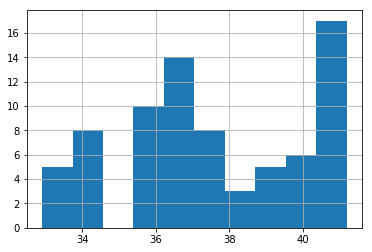

In [32]:
series.hist()
pyplot.show()

In [22]:
print(mags.head(7))

0    2018-03-31T15:07:31.240Z
1    2018-03-31T14:33:39.330Z
2    2018-03-31T09:05:53.260Z
3    2018-03-30T15:05:39.740Z
4    2018-03-30T06:39:56.380Z
5    2018-03-27T22:54:41.190Z
6    2018-03-27T16:27:07.140Z
Name: time, dtype: object


## Csv to time-event dataframe 

In [1]:
from pyspark.sql import *

In [4]:
df = spark.read.option("header","true").csv("/home/user/elicon/data/mars-earthquakes.csv")

In [5]:
df.printSchema()

root
 |-- time: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- depth: string (nullable = true)
 |-- mag: string (nullable = true)
 |-- magType: string (nullable = true)
 |-- nst: string (nullable = true)
 |-- gap: string (nullable = true)
 |-- dmin: string (nullable = true)
 |-- rms: string (nullable = true)
 |-- net: string (nullable = true)
 |-- id: string (nullable = true)
 |-- updated: string (nullable = true)
 |-- place: string (nullable = true)
 |-- type: string (nullable = true)
 |-- horizontalError: string (nullable = true)
 |-- depthError: string (nullable = true)
 |-- magError: string (nullable = true)
 |-- magNst: string (nullable = true)
 |-- status: string (nullable = true)
 |-- locationSource: string (nullable = true)
 |-- magSource: string (nullable = true)



In [40]:
mags = df.select('time', 'mag')

In [41]:
mags

DataFrame[time: string, mag: string]

In [3]:
#saved pipeline model
from pyspark.ml import PipelineModel
pipeModel = PipelineModel.load("/home/user/elicon/src/Training/target/tmp/HashingTF_Binary_pipeline_model_1")

In [4]:
#saved training model
from pyspark.ml.classification import *
trainModel = LogisticRegressionModel.load("/home/user/elicon/src/Training/target/tmp/logisticRegression_Binary_model")

In [19]:
df = df.dropna()

In [20]:
tfidfData = pipeModel.transform(df)

In [21]:
trained_data = trainModel.transform(tfidfData)

In [27]:
from pyspark.sql.functions import from_unixtime
spark.conf.set("spark.sql.session.timeZone", "America/Los_Angeles")
trained_data.select(from_unixtime('time').alias('time'),'text',trained_data.prediction.cast('string').alias('action')).coalesce(1).write.mode('overwrite').option('header', 'true').json('/home/user/tweets-test.json')

## Batch/Interactive Processing

The usual first step in attempting to process the data is to interactively query the data. Let's define a static DataFrame on the files, and give it a table name.

In [28]:
trained_data.select(from_unixtime('time').alias('time'),trained_data.prediction.cast('string').alias('action')).coalesce(1).write.mode('overwrite').option('header', 'true').json('/home/user/tweets-test.json')

In [2]:
from pyspark.sql.types import *
inputPath = '/home/user/tweets-test.json' 
# Since we know the data format already, let's define the schema to speed up processing (no need for Spark to infer schema)
jsonSchema = StructType([ StructField("time", TimestampType(), True), StructField("action", StringType(), True) ])

# Static DataFrame representing data in the JSON files
staticInputDF = (
  spark
    .read
    .schema(jsonSchema)
    .json(inputPath)
)

In [3]:
from pyspark.sql.functions import *      # for window() function

staticCountsDF = (
  staticInputDF
    .groupBy(
       staticInputDF.action, 
       window(staticInputDF.time, "1 hour"))    
    .count()
)
staticCountsDF.cache()

# Register the DataFrame as table 'static_counts'
staticCountsDF.createOrReplaceTempView("static_counts")

In [75]:
total_counts = staticCountsDF.groupBy('action').sum('count')

In [76]:
total_counts.show()

+------+----------+
|action|sum(count)|
+------+----------+
|   1.0|      8612|
|   0.0|       196|
+------+----------+



In [83]:
staticInputDF.orderBy('time','action').show(truncate=False)

+-------------------+------+
|time               |action|
+-------------------+------+
|null               |1.0   |
|2018-02-21 17:40:13|1.0   |
|2018-02-21 17:41:05|1.0   |
|2018-02-21 17:41:12|1.0   |
|2018-02-21 17:41:28|1.0   |
|2018-02-21 17:41:32|0.0   |
|2018-02-21 17:41:32|1.0   |
|2018-02-21 17:42:12|1.0   |
|2018-02-21 17:42:28|1.0   |
|2018-02-21 17:42:49|1.0   |
|2018-02-21 17:43:03|0.0   |
|2018-02-21 17:43:43|1.0   |
|2018-02-21 17:43:45|1.0   |
|2018-02-21 17:43:51|1.0   |
|2018-02-21 17:44:46|1.0   |
|2018-02-21 17:44:46|1.0   |
|2018-02-21 17:44:58|1.0   |
|2018-02-21 17:45:02|1.0   |
|2018-02-21 17:45:35|1.0   |
|2018-02-21 17:45:43|1.0   |
+-------------------+------+
only showing top 20 rows



## Text Preprocessing with SparkNLP

In [ ]:
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.ml import Pipeline
### Define the dataframe                                                               
document_assembler = DocumentAssembler() \
            .setInputCol("text")
assembled = document_assembler.transform(tweet_data)    

In [ ]:
assembled.select('document').show(truncate=False)

In [ ]:
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token") \
  #.addInfixPattern("(\p{L}+)(n't\b)")
tokenized = tokenizer.transform(assembled)    

In [ ]:
tokenized.select('token').show(truncate=False)

In [ ]:
normalizer = Normalizer() \
  .setInputCols(["token"]) \
  .setOutputCol("normalized") \
  .setPattern(r'''(?i)\b((?:https?:\/\/|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''')
normalized = normalizer.transform(tokenized)    

In [ ]:
normalized.select('normalized').show(truncate=False)

In [ ]:
stemmer = Stemmer() \
  .setInputCols(["normalized"]) \
  .setOutputCol("stem")
stemmed = stemmer.transform(normalized)

In [ ]:
stemmed.select('stem').show(truncate=False)

In [ ]:
finisher = Finisher() \
    .setInputCols(["stem"]) \
    .setIncludeKeys(True) \
    .setCleanAnnotations(True)
finished_data = finisher.transform(stemmed)

In [ ]:
pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    normalizer,
    stemmer,
    finisher
])

In [ ]:
spelled_data = pipeline.fit(tweet_data).transform(tweet_data)

In [ ]:
spelled_data.select('finished_stem').show(truncate=False)

In [ ]:
spelled_data.show(truncate=False)

In [ ]:
# Tokenise tweets
from pyspark.ml.feature import Tokenizer
#from pyspark.sql.functions import col, udf
#from pyspark.sql.types import IntegerType

tokenizer = Tokenizer(inputCol="finished_stem", outputCol="words")
#countTokens = udf(lambda words: len(words), IntegerType())
tokenized = tokenizer.transform(finished_data)
#tokenized = tokenized.withColumn("tokens", countTokens(col("words")))

In [ ]:
tokenized.select('words').show(truncate=False)

In [ ]:
from pyspark.ml.feature import StopWordsRemover
# stop words
add_stopwords = ["amp","rt","ca","pg","ga","cb","ap","sce","st"] # standard stop words
stopwordsRemover = StopWordsRemover(inputCol="finished_stem", outputCol="filtered").setStopWords(add_stopwords)
stoped = stopwordsRemover.transform(finished_data)

In [ ]:
# 3-Gram for context feature
from pyspark.ml.feature import NGram

ngram = NGram(n=3, inputCol="filtered", outputCol="ngrams")
#ngrams = ngram.transform(stoped)

## Use HashingTF Feature Extraction

In [ ]:
# Hashing TF feature extraction
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler

hashingTF = HashingTF(inputCol="finished_stem", outputCol="rawFeatures", numFeatures=50000)
featurizedData = hashingTF.transform(finished_data)
#idf = IDF(inputCol="rawFeatures", outputCol="features")

In [ ]:
featurizedData.select('rawFeatures').show(truncate=False)

In [ ]:
from pyspark.ml import Pipeline
#pipeline = Pipeline(stages=[tokenizer,stopwordsRemover, ngram, word2Vec])# Fit the pipeline to training documents.
pipeline = Pipeline(stages=[document_assembler, tokenizer, normalizer, stemmer, finisher, stopwordsRemover, ngram, hashingTF, idf])

In [ ]:
pipelineFit = pipeline.fit(tweet_data)

In [ ]:
jsonSchema = StructType([ StructField("time", TimestampType(), True), StructField("trigger", StringType(), True) ])